# Lorc


In [1]:
import torch
import time
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM

/home/sriney/miniconda3/envs/hawai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- Configuration ---
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "gpt2-large"
generation_length = 1024

print(f"Using device: {device}")

# --- Load Model and Tokenizer ---
tokenizer = AutoTokenizer.from_pretrained(model_name)

print(f"Loading 8-bit model for all tests: {model_name}")
# We only need one model instance for this clean experiment
# This requires `pip install bitsandbytes accelerate`
model = AutoModelForCausalLM.from_pretrained(model_name, load_in_8bit=True)
model.config.use_cache = True

print("Setup complete.")

# --- VRAM Monitoring Helper Function ---
def get_vram_usage():
    """Returns the current GPU memory usage in GB."""
    if device == "cuda":
        return torch.cuda.memory_allocated(0) / (1024**3)
    return 0

Using device: cuda
Loading 8-bit model for all tests: gpt2-large


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


KeyboardInterrupt: 

In [ ]:
def analyze_inference_baseline(model, tokenizer):
    """
    Runs a baseline test with a full KV cache.
    """
    print(f"\n--- Running test for strategy: 'True Baseline (8-bit)' ---")
    input_ids = torch.tensor([[tokenizer.bos_token_id]], dtype=torch.long).to(device)
    past_key_values = None
    timings = []
    vram_usage = []
    
    with torch.no_grad():
        for i in range(generation_length):
            start_time = time.perf_counter()
            outputs = model(input_ids=input_ids[:, -1:], past_key_values=past_key_values, use_cache=True)
            next_token_id = torch.argmax(outputs.logits[:, -1, :], dim=-1).unsqueeze(-1)
            input_ids = torch.cat([input_ids, next_token_id], dim=-1)
            past_key_values = outputs.past_key_values
            end_time = time.perf_counter()
            
            timings.append((end_time - start_time) * 1000)
            vram_usage.append(get_vram_usage())
            
            if (i + 1) % 100 == 0:
                print(f"Generated {i + 1}/{generation_length} tokens...")
    
    print(f"'True Baseline (8-bit)' test complete.")
    return timings, vram_usage

def analyze_and_simulate_lorc(model, tokenizer, rank_ratio):
    """
    Runs a full inference and SIMULATES the memory savings of LoRC.
    The latency measured will be that of a standard model, which is expected for LoRC.
    """
    print(f"\n--- Running test for strategy: 'LoRC Simulated (Memory Only)' ---")
    
    # Measure the base memory of the model itself, without any cache
    model_base_vram = get_vram_usage()

    input_ids = torch.tensor([[tokenizer.bos_token_id]], dtype=torch.long).to(device)
    past_key_values = None
    timings = []
    vram_usage_simulated = []

    with torch.no_grad():
        for i in range(generation_length):
            start_time = time.perf_counter()
            
            outputs = model(input_ids=input_ids[:, -1:], past_key_values=past_key_values, use_cache=True)
            
            past_key_values = outputs.past_key_values
            
            next_token_id = torch.argmax(outputs.logits[:, -1, :], dim=-1).unsqueeze(-1)
            input_ids = torch.cat([input_ids, next_token_id], dim=-1)
            end_time = time.perf_counter()

            # --- VRAM Simulation Logic ---
            # 1. Get the actual VRAM usage with the full cache
            actual_vram = get_vram_usage()
            # 2. Calculate the size of the full cache
            full_cache_vram = actual_vram - model_base_vram
            # 3. Calculate the size of our simulated smaller cache
            simulated_cache_vram = full_cache_vram * rank_ratio
            # 4. Store the simulated total VRAM
            vram_usage_simulated.append(model_base_vram + simulated_cache_vram)

            timings.append((end_time - start_time) * 1000)
            
            if (i + 1) % 100 == 0:
                print(f"Generated {i + 1}/{generation_length} tokens...")
                
    print(f"'LoRC Simulated' test complete.")
    return timings, vram_usage_simulated

In [ ]:
# --- Configuration for the LoRC simulation ---
lorc_ratio = 0.5 # Simulate a 50% compression, expecting ~50% cache memory savings

# --- Run the Two Experiments ---
baseline_timings, baseline_vram = analyze_inference_baseline(model, tokenizer)
lorc_timings, lorc_simulated_vram = analyze_and_simulate_lorc(model, tokenizer, rank_ratio=lorc_ratio)



--- Running test for strategy: 'True Baseline (8-bit)' ---
Generated 100/1024 tokens...
Generated 200/1024 tokens...
Generated 300/1024 tokens...
Generated 400/1024 tokens...
Generated 500/1024 tokens...
Generated 600/1024 tokens...
Generated 700/1024 tokens...
Generated 800/1024 tokens...
Generated 900/1024 tokens...
Generated 1000/1024 tokens...
'True Baseline (8-bit)' test complete.

--- Running test for strategy: 'LoRC Simulated (Memory Only)' ---
Generated 100/1024 tokens...
Generated 200/1024 tokens...
Generated 300/1024 tokens...
Generated 400/1024 tokens...
Generated 500/1024 tokens...
Generated 600/1024 tokens...
Generated 700/1024 tokens...
Generated 800/1024 tokens...
Generated 900/1024 tokens...
Generated 1000/1024 tokens...
'LoRC Simulated' test complete.


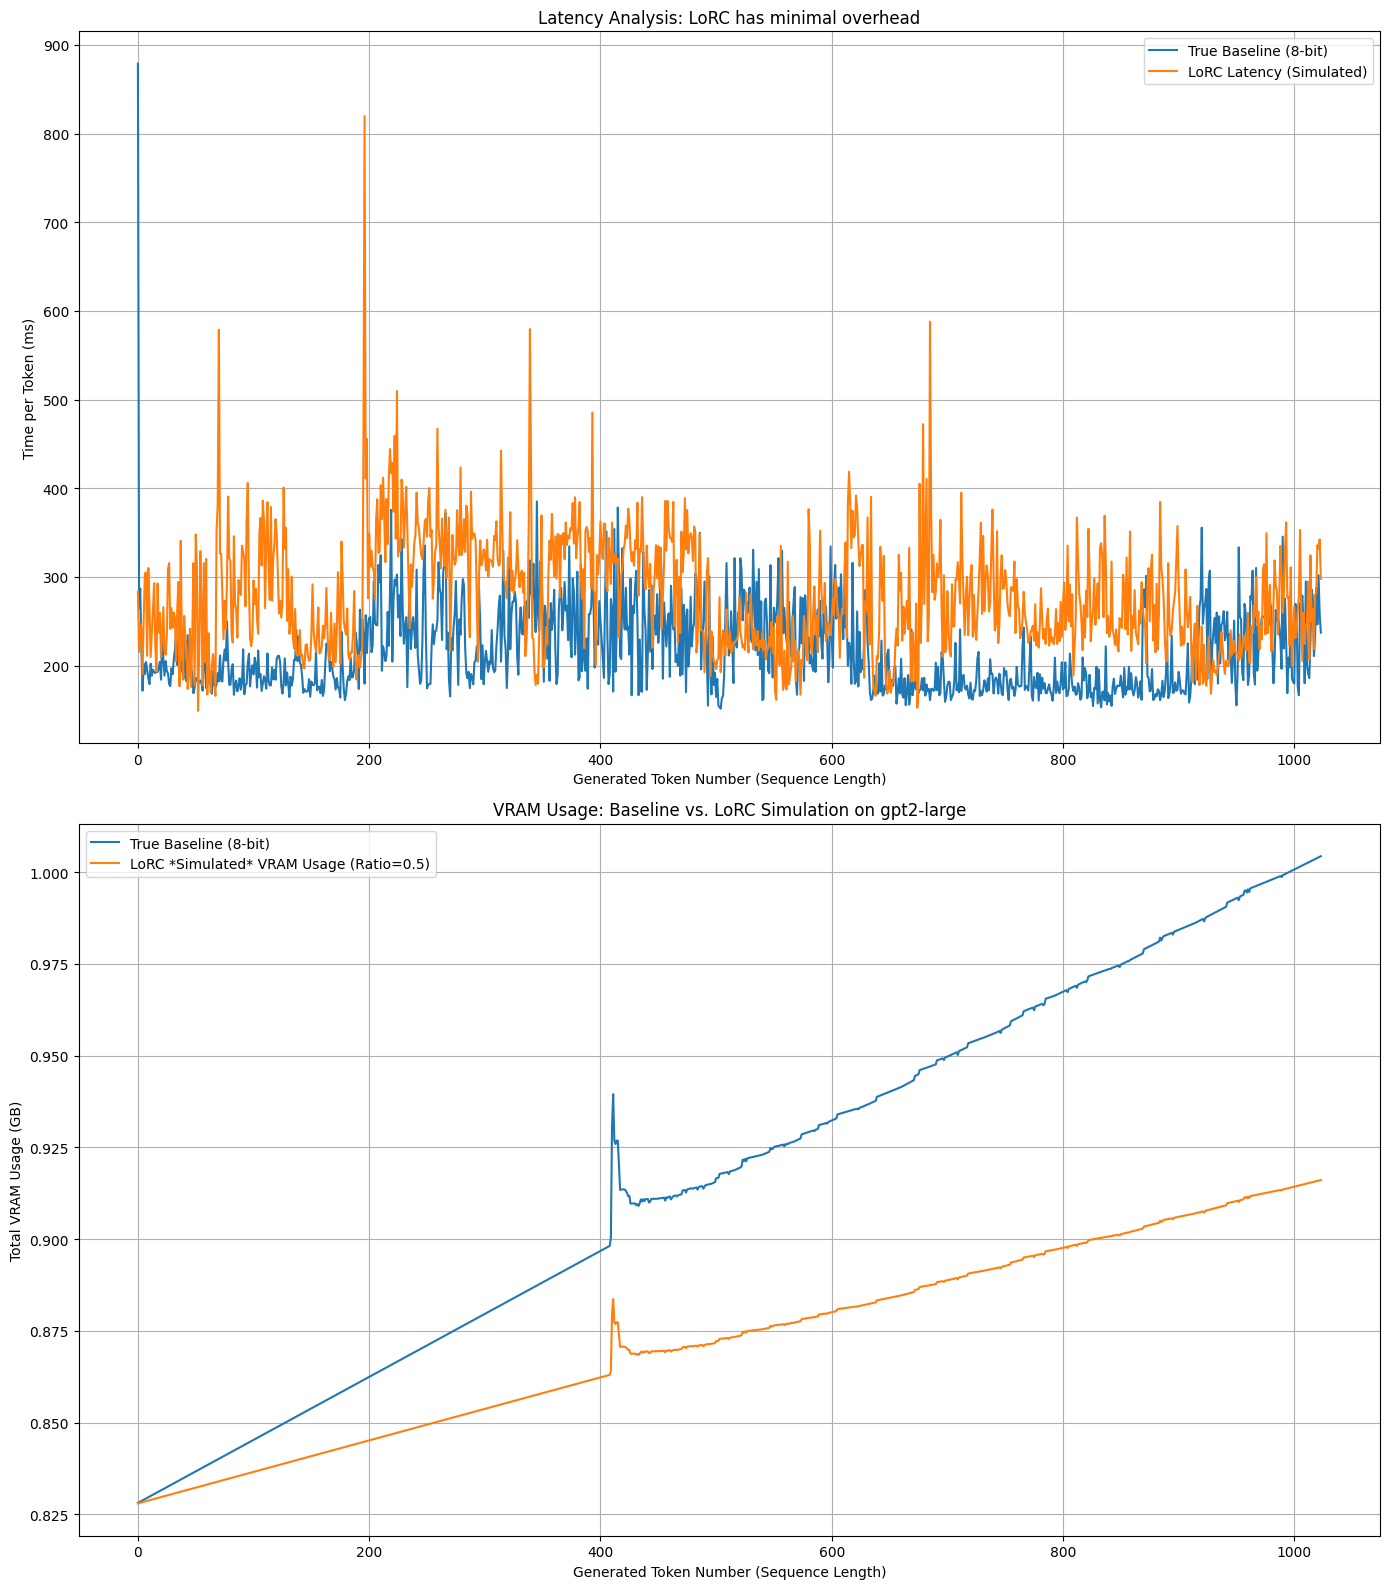


--- Analysis complete. ---


In [ ]:
# --- Create the Plots ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 16))

# Plot 1: Latency (Time per Token)
ax1.plot(baseline_timings, label='True Baseline (8-bit)')
ax1.plot(lorc_timings, label=f'LoRC Latency (Simulated)')
ax1.set_xlabel('Generated Token Number (Sequence Length)')
ax1.set_ylabel('Time per Token (ms)')
ax1.set_title(f'Latency Analysis: LoRC has minimal overhead')
ax1.legend()
ax1.grid(True)

# Plot 2: VRAM Usage
ax2.plot(baseline_vram, label='True Baseline (8-bit)')
ax2.plot(lorc_simulated_vram, label=f'LoRC *Simulated* VRAM Usage (Ratio={lorc_ratio})')
ax2.set_xlabel('Generated Token Number (Sequence Length)')
ax2.set_ylabel('Total VRAM Usage (GB)')
ax2.set_title(f'VRAM Usage: Baseline vs. LoRC Simulation on {model_name}')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print("\n--- Analysis complete. ---")